# Вспомогательный код

Код из лекции который понадобится при выполнении практических заданий.
Выполните ячейки этого блока перед началом работы


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

from itertools import product, chain

sns.set_style("whitegrid")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_CUDA = True

In [2]:
def plot_manifold(latent_r, labels=None, alpha=0.5):
    plt.figure(figsize=(10,10))
    if labels is None:
      plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=0.9)
    else:
      plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=0.9)
      plt.colorbar()
    plt.show()

def plot_digits(*args, invert_colors=True, digit_size = 28, name=None):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 
                        2*len(args))
              )
    
    plt.imshow(figure,
               cmap='Greys_r',
               clim=(0,1))
    
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

def train(enc, 
          dec,
          loader, 
          optimizer, 
          single_pass_handler, 
          loss_handler,
          epoch, 
          log_interval=500):
    for batch_idx, (data, lab) in enumerate(loader):
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(enc, dec, data, lab)

        loss = loss_handler(data, output, latent)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))
            
def ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recons = decoder(latent)
    return latent, recons

def ae_loss_handler(data, recons, *args, **kwargs):
    return F.binary_cross_entropy(recons, data)

def run_eval(encoder, 
             decoder, 
             loader, 
             single_pass_handler,
             return_real=True, 
             return_recontr=True,
             return_latent=True,
             return_labels=True):
  
    if return_real:
        real = []
    if return_recontr:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, lab) in enumerate(loader):  
            if return_labels:
                labels.append(lab.numpy())
            if return_real:
                real.append(data.numpy())
            
            data = data.to(device)
            lab = lab.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, lab)
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recontr:
                reconstr.append(rec.cpu().numpy())
    
    result = {}
    if return_real:
        real = np.concatenate(real)
        result['real'] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result['latent'] = latent
    if return_recontr:
        reconstr = np.concatenate(reconstr)
        result['reconstr'] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result['labels'] = labels
    return result


In [3]:
#handson-ml2

import matplotlib as mpl
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

  
def plot_activations_histogram(activations, height=1, n_bins=10):
    activation_means = activations.mean(axis=0)
    
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, activations.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])



In [4]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []
        in_channels = 1
        for h_dim in hidden_dims[:-1]:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_channels,
                              out_channels=h_dim,
                              kernel_size= 3, stride= 2 , padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=256,
                              out_channels=512,
                              kernel_size= 1),
                    nn.BatchNorm2d(512),
                    nn.LeakyReLU())
        )
        modules.append(nn.Flatten())
        modules.append(nn.Linear(hidden_dims[-1] * 4, latent_size))

        self.encoder = nn.Sequential(*modules)      
    
    def forward(self, x):
        x = self.encoder(x)
        return x
        
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(in_features=latent_size, 
                                out_features=hidden_dims[0])
        
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )


        modules.append(nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 7, padding= 1),
                            nn.Sigmoid()))

        self.decoder = nn.Sequential(*modules)   

        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

# Задание 1. Автоенкодер для KMNIST c MSE-loss

Подзадачи:

* Обучите автоэнкодер на [KMNIST](http://codh.rois.ac.jp/kmnist/index.html.en) датасете

Используйте енкодер и декоодер из лекции, но уберите из декодера сигмоиду в конце. В связи с этим, при обучении надо будет использовать MSE-loss между реальным и восстановленным изображением.


* Как выглядит латентное представление? Разделяются ли в нем классы? 

* Теперь обучите автоенкодер с размером латентного слоя 30

* Продемонстрируйте восстановление автоенкодером переданных ему избражений? 


Чем восстановление отличается от восстановления автоенкодером, обученном в лекции? Что не нравится в полученных востановленных изображениях?

#### Загрузка датасета KMNIST

In [16]:
root = './data'

train_set = dset.KMNIST(root=root, 
                       train=True, 
                       transform=torchvision.transforms.ToTensor(),
                       download=True)
test_set = dset.KMNIST(root=root, 
                      train=False,
                      transform=torchvision.transforms.ToTensor(),
                      download=True)

test_noise_set = dset.KMNIST(root=root, 
                      train=False,
                      transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),
                          AddGaussianNoise(0., 0.30)
                      ]),
                      download=True)
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=64,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=64,
    shuffle=False)

test_noised_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_noise_set, list(range(64))),
    batch_size=64, 
    shuffle=False)



#### Задача 1.1

Используйте энкодер и декодер из лекции, но уберите из декодера сигмоиду в конце. В качестве лосс используйте MSE между реальным и восстановленным изображением.

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(in_features=latent_size, 
                                out_features=hidden_dims[0])
        
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )


        modules.append(nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 7, padding= 1),
                            ))

        self.decoder = nn.Sequential(*modules)   

        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

In [18]:
def mse_loss_handler(data, recons, *args, **kwargs):
    return F.mse_loss(recons, data)

In [21]:
latent_size = 2
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

In [22]:
for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=mse_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.265196
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.096412
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.090017
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.087023
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.088735
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089597
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.090195
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.081938
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.082457
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.085888
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.079966
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.083490
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.085148
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.086279
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.077383
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.081394
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.077814
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.082963
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.074978
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.075987
Train Epoch:

#### Задача 1.2

Визуализируйте латентное представление. Разделяются ли в нем классы? 

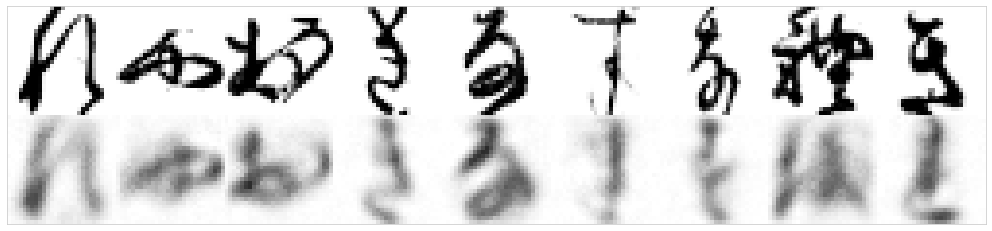

In [23]:
encoder = encoder.eval()
decoder = decoder.eval()
run_res = run_eval(encoder, decoder, test_loader, ae_pass_handler)
plot_digits(run_res['real'][0:9], run_res['reconstr'][0:9])

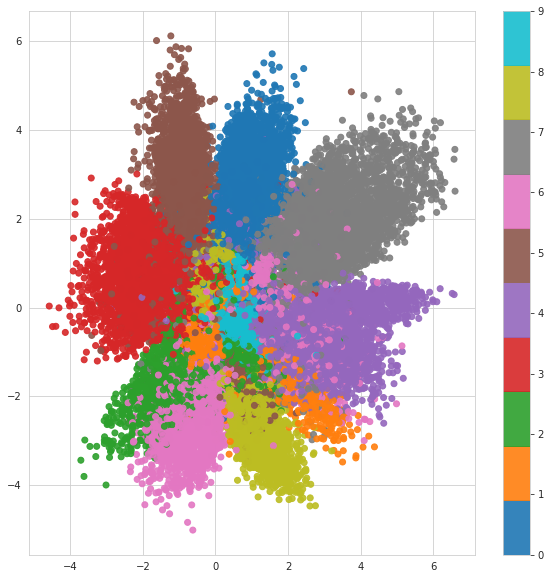

In [24]:
plot_manifold(run_res['latent'], run_res['labels'])

 #### Задача 1.3 
 Обучите автоенкодер с размером латентного слоя равным 30

In [25]:
latent_size = 30
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

In [27]:
for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=mse_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.237281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.079215
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.068179
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.055214
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.046328
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.048054
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.044146
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.039491
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.038216
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.040367
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.038313
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.039740
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.039886
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.036277
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.036691
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.032805
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.032546
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.033993
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.033580
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.033039
Train Epoch:

 #### Задача 1.4 Продемонстрируйте восстановление автоенкодером переданных ему избражений

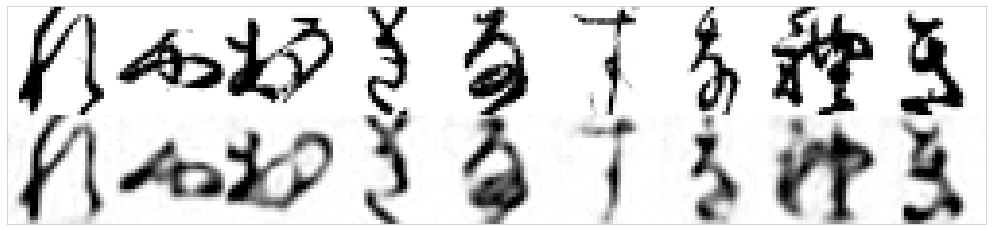

In [28]:
encoder = encoder.eval()
decoder = decoder.eval()
run_res = run_eval(encoder, decoder, test_loader, ae_pass_handler)
plot_digits(run_res['real'][0:9], run_res['reconstr'][0:9])

#### 1.3 Вывод

Чем восстановление отличается от восстановления автоенкодером, обученном в лекции? Какие дефекты видны на востановленных изображениях?


...

 В следующих заданиях будет использоваться обычный MNIST

In [6]:

root = './data'

train_set = dset.MNIST(root=root, 
                       train=True, 
                       transform=torchvision.transforms.ToTensor(),
                       download=True)
test_set = dset.MNIST(root=root, 
                      train=False,
                      transform=torchvision.transforms.ToTensor(),
                      download=True)

test_noise_set = dset.MNIST(root=root, 
                      train=False,
                      transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),
                          AddGaussianNoise(0., 0.30)
                      ]),
                      download=True)
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=64,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=64,
    shuffle=False)

test_noised_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_noise_set, list(range(64))),
    batch_size=64, 
    shuffle=False)



### Задание 2. Разреженный autoencoder с KL-loss

На занятии мы обсуждали, что разреженный автоенкодер можно делать двумя путями - при помощи L1 и при помощи KL лосса.

Ваша задача состоит в том, чтобы реализовать разреженный автоенкодер с KL-лоссом. 

Обучите автоенкодер с требованием, чтобы активировалось не более 10% нейронов. 

Напоминаем, что в этом случае мы:
 1. усредняем активации по батчу. 
 2. для каждого нейрона таким образом получаем среднюю "вероятность" активироваться
 3. Эта вероятность вряд ли будет в точности равна 0 или 1, но в выражение для KL-loss в знаменатель на всякий случае добавляем малое число epsilon.
 4. Подсчитанный лосс усредняем по всем нейронам слоя
 5. Сделайте выводы

Кроме того, учтите, что лосс надо считать по активациям, распределенным от 0 до 1 - то есть надо выполнить преобразование, аналогичное тому, что мы делали ранее


Сделайте вывод:

 1. Того, как восстанавливает полученные автоенкодер изображения
 2. Средних активаций для каждого класса 
 3. Распределения силы активаций в целом и средней силы активации каждого нейрона


$$KL(P||Q) =  p(x) \log \dfrac {p(x)} {\hat{p}(x) + \epsilon} + (1 - p(x)) \log \dfrac {(1 - p(x))} {1 - \hat{p}(x) + \epsilon} $$

### Задача 2.1 Обучаем VAE

In [9]:
def to_01_activation(latent):
  activations = 2*(torch.sigmoid(latent.abs()) - 0.5)
  return activations

def sparse_kl_loss(latent, p=0.10, eps=10e-5):
  activations = to_01_activation(latent)
  q = activations.mean(axis=0) # Put your code here  
  loss = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q)) # Put your code here 
  return loss.mean()

def sparse_ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recons = decoder(latent)
    return latent, recons

def sparse_ae_loss_handler(data, recons, latent, beta=0.1, *args, **kwargs):
    return F.binary_cross_entropy(recons, data) + sparse_kl_loss(latent)

In [10]:
latent_size = 16 * 16

learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)


encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = optim.Adam(chain(encoder.parameters(),
                            decoder.parameters()
                           ),
                      lr=learning_rate)

In [11]:
from functools import partial

for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=sparse_ae_pass_handler,
        loss_handler=partial(sparse_ae_loss_handler, beta=0.01),
        log_interval=450,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.779611
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.111747
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.087757
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.089486
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.086654
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.080960
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085288
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.084067
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.081926
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.076956
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.077533
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.072859
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.073094
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.074987
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.075537


### Задача 2.2

Как автоенкодер восстанавливает полученные изображения

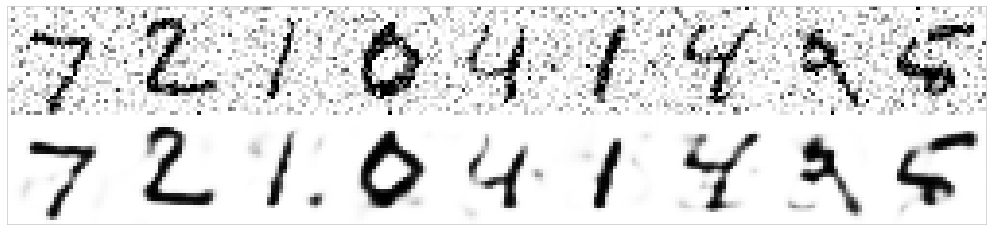

In [12]:
encoder = encoder.eval()
decoder = decoder.eval()
run_res = run_eval(encoder, decoder, test_noised_dataloader, sparse_ae_pass_handler)
plot_digits(run_res['real'][0:9], run_res['reconstr'][0:9])

### Задача 2.3 

Средние активаций для каждого класса 

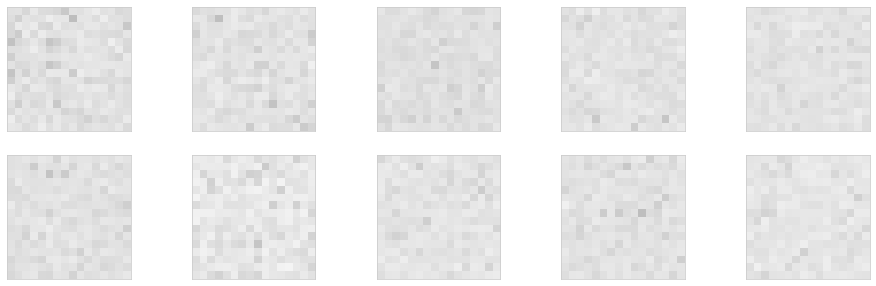

In [13]:
run_res = run_eval(encoder, decoder, test_loader, sparse_ae_pass_handler)
_, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 5))
activations = to_01_activation(torch.from_numpy(run_res["latent"])).numpy()

up_lim = activations.max()
for label in range(0, 10):

    figure = activations[run_res["labels"] == label].mean(axis=0)
    figure = figure.reshape(16, 16)
    ax = axs[label % 2, label % 5]
    ax.imshow(figure, cmap="Greys", clim=(0, 0.5))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Задача 2.4 

Распределения силы активаций в целом и средней силы активации каждого нейрона

In [14]:
# handson-ml2

import matplotlib as mpl


def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths * 0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(
            lambda y, position: "{}%".format(int(np.round(100 * y)))
        )
    )
    ax.grid(True)


def plot_activations_histogram(activations, height=1, n_bins=10):
    activation_means = activations.mean(axis=0)

    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, activations.ravel(), bins)
    ax1.plot(
        [mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean)
    )
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

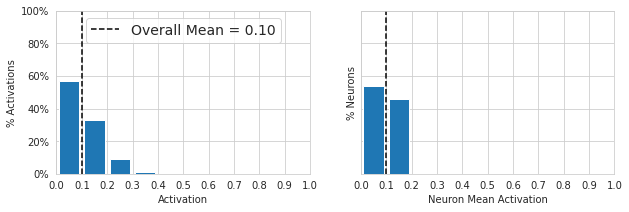

In [15]:
plot_activations_histogram(activations, height=1.0)
plt.show()

### Задание 3 Сэмплирование из обычного VAE

В случае с обычным VAE мы визуализировали только центры распределений, соответствувющих цифрам. Хотелось бы получить более полное представление о том, как выглядит латентное пространство. 

Подзадачи:
 1. Обучить VAE из лекции (latent_size = 2)
 2. Визуализировать латентные представления, который приходят на вход decoder. Для этого можно воспользоваться функцией vae_reparametrization, ввозможно, переписав ее на numpy (один из вариантов) Из каждого распределения, соответствующего объекту надо сэмплировать несколько раз. Хотя бы 10. Чтобы точки на полученном графике не полностью перекрывались, используйте параметр alpha из sns.scatterplot или plot_manifold из лекции

In [7]:
class VAEEncoder(Encoder):
    def __init__(self, latent_size):
        if latent_size % 2 != 0:
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_size)

def vae_split(latent):
    size = latent.shape[1] // 2
    mu = latent[:, :size]
    log_var = latent[:, size:]
    return mu, log_var

def vae_reparametrize(mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    z = torch.randn(mu.shape[0], mu.shape[1]).to(device)
    return z * sigma + mu 

def vae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    recons = decoder(sample)
    return latent, recons

# Compare predicted distribution with unit Gaussian mu = 0 var = 1  
def kld_loss(mu, log_var):
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - var, dim = 1),
                          dim = 0)  
    return kl_loss

def vae_loss_handler(data, recons, latent, kld_weight=0.005, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    return kld_weight * kl_loss + F.binary_cross_entropy(recons, data)

In [49]:
?torch.randn

### Задание 3.1 

Обучаем VAE 

In [8]:
latent_size = 2

learning_rate = 1e-4
encoder = VAEEncoder(latent_size=latent_size * 2)
decoder = Decoder(latent_size=latent_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in range(1, 3):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=450,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.652052
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.256930
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.227576
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.226189
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.218985
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.209621


### Задание 3.2

Визуализируйте латентные представления, который приходят на вход decoder.

*Для этого можно воспользоваться функцией vae_reparametrization, ввозможно, переписав ее на numpy*

 Из каждого распределения, соответствующего объекту надо сэмплировать несколько раз. Хотя бы 10. Чтобы точки на полученном графике не полностью перекрывались, используйте параметр alpha из sns.scatterplot или plot_manifold из лекции

In [9]:
def vae_reparametrize_np(mu, log_var):
    sigma = np.exp(0.5 * log_var)
    z = np.random(mu.shape[0], mu.shape[1]).to(device)
    return z * sigma + mu 

In [29]:
number = []
batch_idx, (data, lab) = enumerate(test_loader).__next__()
run_res = run_eval(encoder, decoder, test_loader, vae_pass_handler)
mu, log_var = vae_split(run_res["latent"])

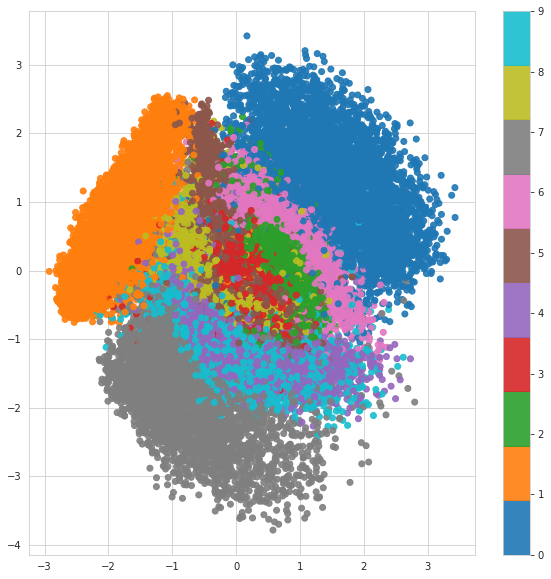

In [30]:
plot_manifold(mu, run_res['labels'])

### Задание 3.3

Визуализация латетного пространства

Для VAE , можно получить распределение классов цифр на плоскости, типа такого:

<img src="https://edunet.kea.su/repo/src/L14_Encoders/img/vae_sampling.png" alt="alttext" style="width: 300px;"/>

Вашей задачей будет получить похожее изображение. Используйте побольше изображений в каждом ряду (скажем, 50). Иначе все цифры можете не увидеть

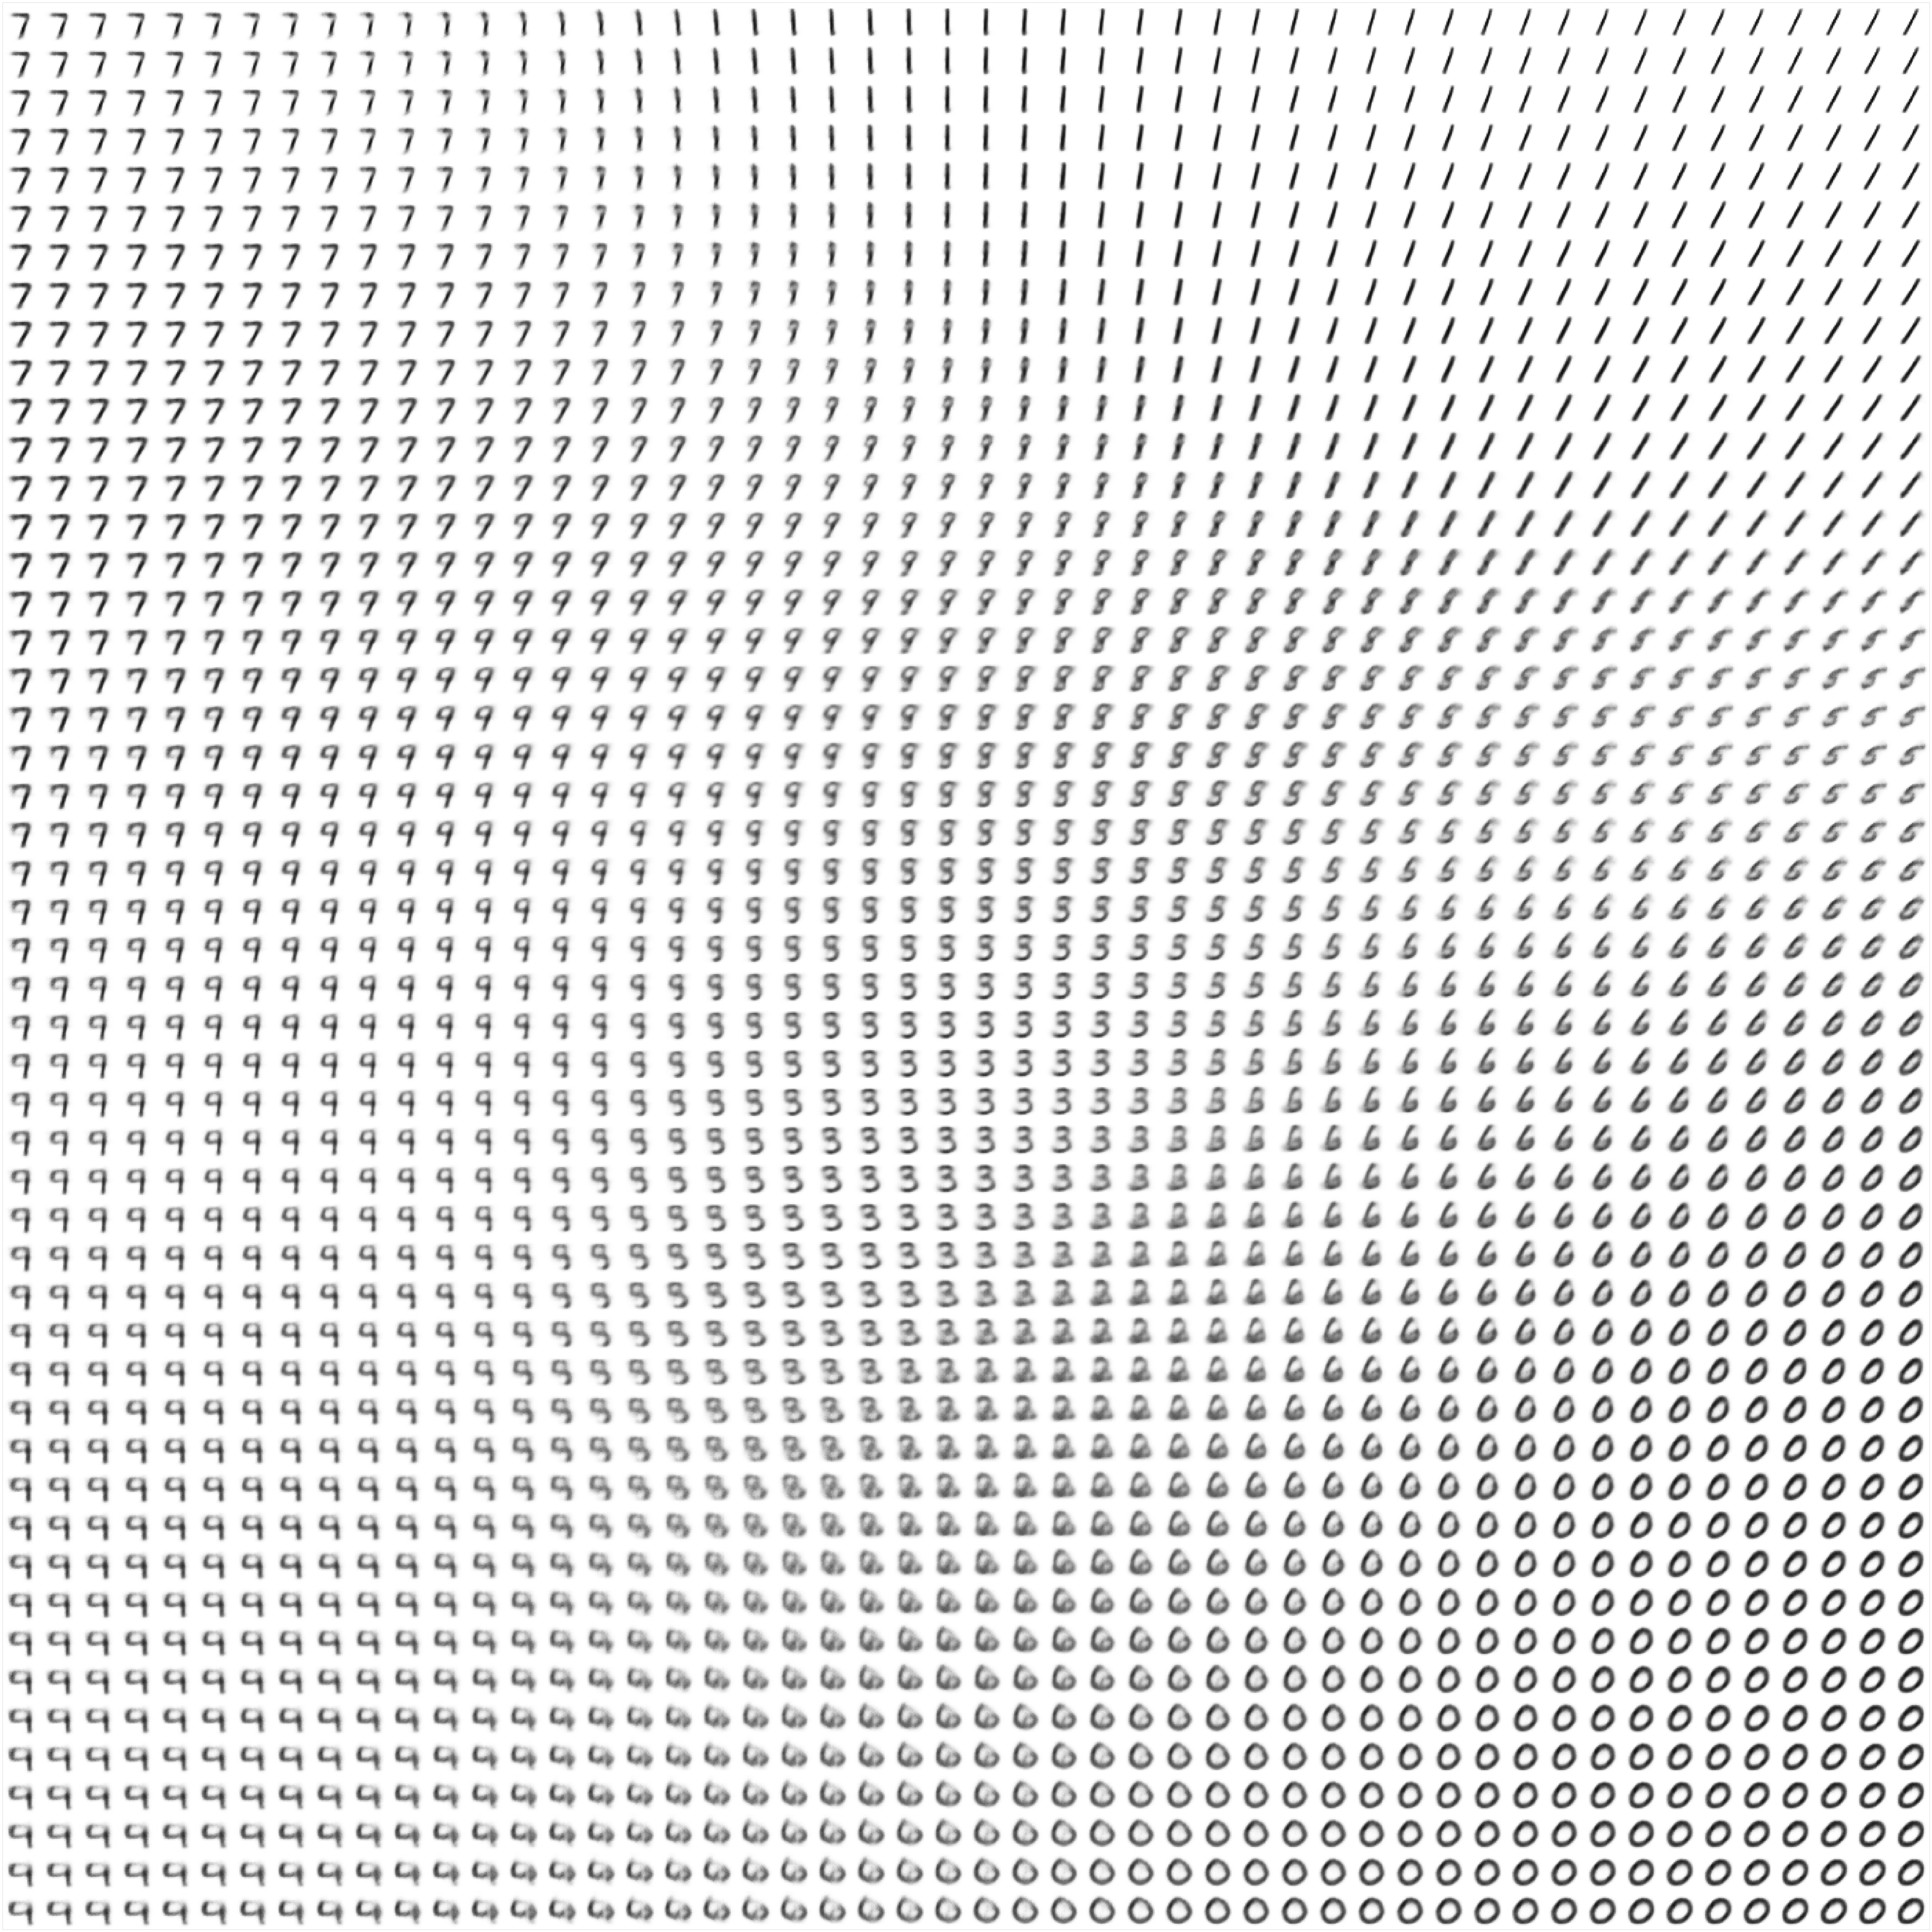

In [36]:
steps = 50
space1 = torch.linspace(-2, 2, steps)
space2 = torch.linspace(-2, 2, steps)
grid = torch.cartesian_prod(space1, space2)
with torch.no_grad():
    images = decoder(grid.cuda())
    images = images.cpu().numpy().squeeze()
plot_digits(*[images[x : x + steps] for x in range(0, steps * steps, steps)])

### Задание 4. Перенос стиля при помощи CVAE

Обучите CVAE из лекции (latent_size=2)


Воспроизведем теперь картинку с результатами переноса стилей для нескольких разных 7

<img src="https://edunet.kea.su/repo/src/L14_Encoders/img/style_transfer.png" alt="alttext" style="width: 200px"/>. 


Но для троек

Набираем себе 10 разных троек. Желательно брать не просто первые 10, а, к примеру, случайные 10 троек из датасета (seed зафиксируем)

Копируем CVAE код из лекции

In [83]:
class CDecoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(
            in_features=latent_size + 10, out_features=hidden_dims[0]
        )

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x, lab):
        x = torch.cat([x, lab], dim=1)
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

In [84]:
def cvae_pass_handler(encoder, decoder, data, lab, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    lab = torch.nn.functional.one_hot(lab, num_classes=10)
    recons = decoder(sample, lab)
    return latent, recons

In [85]:
latent_size = 2

learning_rate = 1e-2
encoder = VAEEncoder(latent_size=latent_size * 2)
decoder = CDecoder(latent_size=latent_size)


encoder = encoder.cuda()
decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
from functools import partial

for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=cvae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=450,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.672376
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.200205
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.194699
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.200996
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.192408
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.190778
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.195114
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.191147
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.191088
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.192889
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.193507
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.210626
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.181144
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.178590
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.185192


In [86]:
encoder = encoder.eval()
decoder = decoder.eval()

In [87]:
run_res = run_eval(encoder, decoder, test_loader, cvae_pass_handler)

In [88]:
import random
random.seed(60)
images, labels = next(iter(test_loader))
#print(images.shape)
img_list = []
i, =np.where(run_res['labels'] == 3)
for _ in range(10):
  k = random.choice(i)
  img_list.append(torch.tensor(run_res['real'][k]))

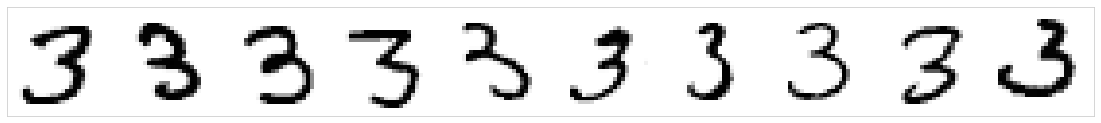

In [103]:
plot_digits(img_list)

In [95]:
latent_list = []
for i in range(10):
  mu, log_var = vae_split(encoder(torch.unsqueeze(torch.unsqueeze(img_list[i], 0), 0).cuda()))
  sigma = torch.exp(0.5 * log_var)
  z = torch.randn(10, mu.shape[1]).cuda()
  latent_list.append(z * sigma + mu)

In [99]:
images = []
lab = torch.tensor(range(0,10))
lab = torch.nn.functional.one_hot(lab, num_classes=10)
with torch.no_grad():
  for i in range(10):
    images.append(decoder(latent_list[i].cuda(), lab.cuda()))
    images[i] = np.squeeze(images[i].cpu())

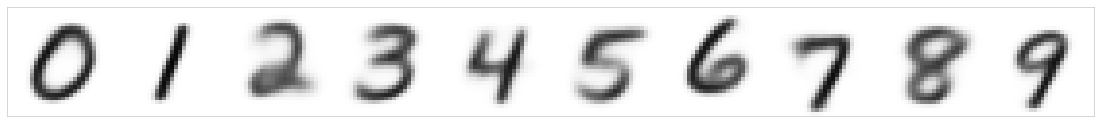

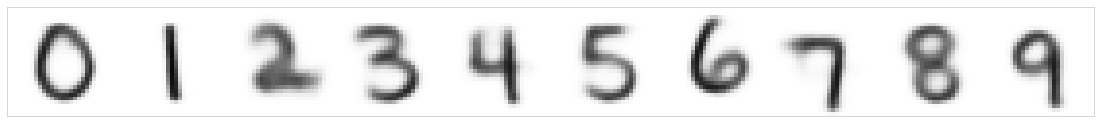

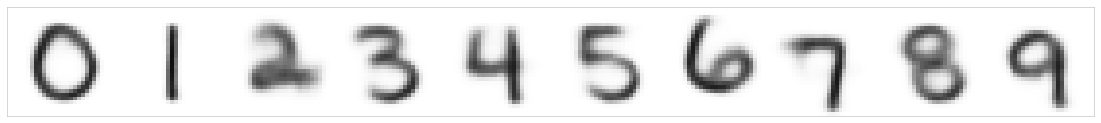

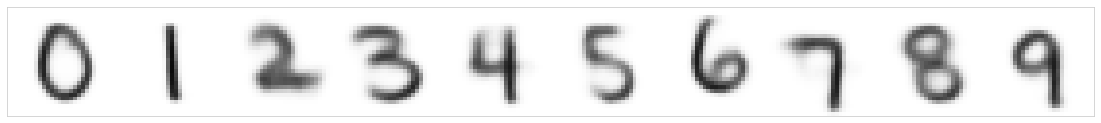

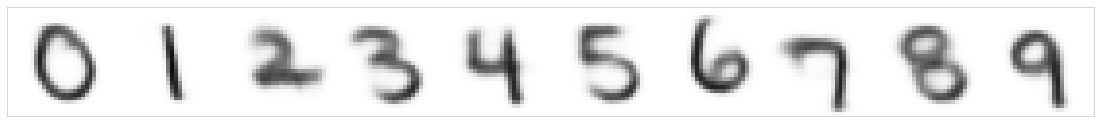

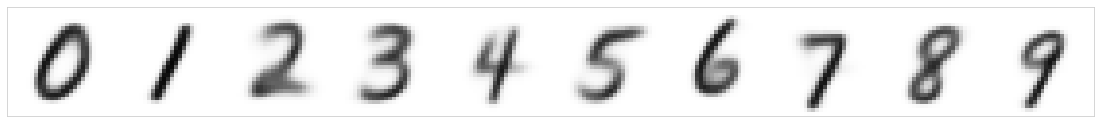

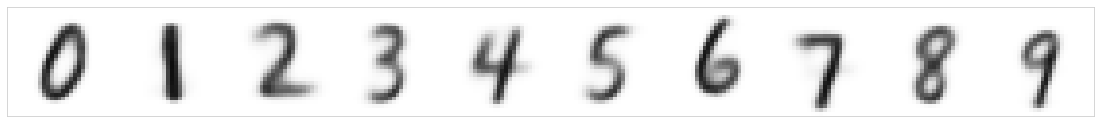

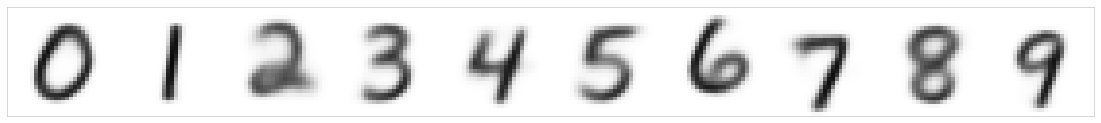

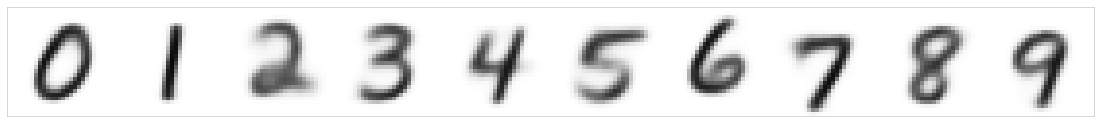

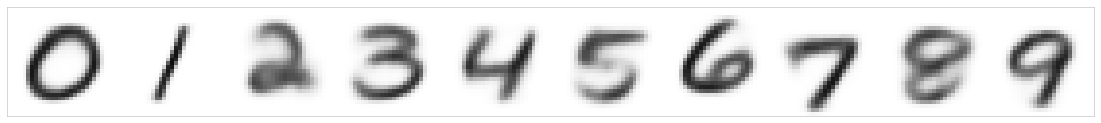

In [101]:
for i in range(10):
  plot_digits((images[i]))

### Задание 5. Conditional adversarial autoencoder* (Дополнительное)

У нас есть AAE. У нас есть Conditional Autoencoders.

Осталось скрестить. Конкретно - теперь будем передавать метку декодеру.

Но не только. Что произойдет, если не передавать метку дискриминатору, но при этом передавать метку декодеру? 

Правильно, автоенкодеру может оказаться выгоднее игнорировать метку и "зарезервировать" под каждую цифру только часть латентного пространства. 
Мы так не хотим. Потому необходимо добавить в дискриминатор метку - получим "условный" дискриминатор

Остается еще один вопрос - что передавать ему в качестве метки, когда мы передаем ему сэмплы из равномерного распределения? 
Будем просто передавать ему равное число меток разных классов. Можно просто сделать так, что число положительных примеров было кратно 10 (рекомендую), можно выбирать метки случайно. 

Таким образом, надо:

1. Реализовать "условный" дискриминатор
2. Поменять цикл обучение так, чтобы использовать условный декодер и условный дискриминатор.
3. Для обученного автоенкодера посэмплировать 4 и еще одну любую выбранную вами цифру

4. **Допбаллы**: можете проверить, что будет, если использовать обычный дискриминатор. Действительно ли нейросеть каждому объекту начнет сопоставлять лишь часть пространства

Учтите, что может быть полезным еще больше увеличить размер батча с реальными изображениями. Для батча размера 128 на 10 классов изображений получится, что на каждой итерации для латентного пространства каждой цифры используется порядка 12 изображений, что не очень много.

Равномерное распределение можете взять на отрезке от -1 до 1

In [ ]:
def generate_uniform(shape): # U[-1, 1]
  return torch.rand( *shape ) * 2 - 1

In [ ]:
class CDiscriminator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.discriminator = nn.Sequential(nn.Linear(latent_size + 10, 512),
                                           nn.BatchNorm1d(512),
                                           nn.LeakyReLU(0.2),
                                           nn.Linear(512, 256),
                                           nn.BatchNorm1d(256),
                                           nn.LeakyReLU(0.2),
                                           nn.Linear(256, 1),
                                           nn.Sigmoid())
        
    def forward(self, x, lab):
        x = ...
        x = self.discriminator(x)
        return x